## Time-Delay Embedded and Multivariate Auto Regressive Hidden Markov Models

This notebook shows examples of training and inspecting a Time-Delay Embedded Hidden Markov Model (TDE-HMM) and a Multivariate Auto Regressive Hidden Markov Model (MAR-HMM). 

The TDE-HMM and MAR-HMM are trained on Magnetoencephalogram (MEG) data. The TDE-HMM is trained on whole-brain data, while the MAR-TDE is trained on only two-channel data. 

This notebook showcases also how to perform spectral analysis on the HMM states, including computing the states power spectra and the states cross-channel coherence.

**Note:** Due to rendering issues when viewing this notebook through github, internal links, like the table of contents, may not work correctly. To ensure that the notebook renders correctly, you can view it through [this link](https://nbviewer.org/github/vidaurre/glhmm/blob/main/docs/notebooks/HMM-TDE_vs_HMM-MAR_example.ipynb).

Authors: Laura Masaracchia <laurama@cfin.au.dk>

## Outline
1. [Background](#background)
2. [Preparation](#preparation)
3. [TDE-HMM example](#HMM-TDE)
    * [Load and preprocess data](#load-data-tde)
    * [Initialise and train a TDE-HMM](#initialise-hmm-tde)
    * [Inspect model](#inspect-model)
    * [Spectral analysis](#spectral-tde)
    
4. [MAR-HMM example](#HMM-MAR)
    * [Load data](#load-data-mar)
    * [Initialise and train a MAR-HMM](#initialise-hmm-mar)
    * [Relate states to behaviour](#onset)
    * [Spectral analysis](#spectral-mar)

## Background <a id="background"></a>

The MAR-HMM was introduced in [Vidaurre et al. (2016)](https://www.sciencedirect.com/science/article/pii/S1053811915010691). Given a multichannel time series *y*, the MAR-HMM models estimates the probability of each time point of the data of belonging to state *k* by using a multivariate autoregressive model. This means that for each time point data *yt*, the MAR-HMM tries to find a linear combination of the previous P time points to predict *yt*. P is in this case a HMM parameter that has to be specified by the user, called "order". The states here are the weights estimated in the prediction process.

The TDE-HMM was introduced in [Vidaurre et al. (2018)](https://www.nature.com/articles/s41467-018-05316-z). This HMM models the autocovariance of the signal. Given a multichannel time series data *y*, the autocovariance is computed within a window of length 2L and resolution S around each time point *yt*. The window is specified by the user in the form (-L, -L+S, ...-S, 0, S, ..., L-S, L), which indicates the time points around t to be included in the window. Then, the data are restructured according to the lags embedding, and the HMM is run on the embedded data. Here, the states are the covariance matrices that best describe the signal. 

The TDE-HMM is typically preferred for high-dimensional data, while the MAR-TDE can be more precise in detecting frequency and amplitude related states.
Check [Masaracchia et al. (2023)](https://journals.physiology.org/doi/full/10.1152/jn.00054.2023) for a comparison between the MAR-HMM and TDE-HMM working mechanisms, biases and expected outcomes. 


## Preparation <a id="preparation"></a>
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install glhmm```

We will then import the necessary libraries and modules for this notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from glhmm import glhmm, preproc, utils, graphics, spectral, io, statistics, auxiliary
import pickle
import scipy

## TDE-HMM Example: Modelling whole-brain MEG data <a id="HMM-TDE"></a>

For this example, we will use whole-brain MEG resting state data. The data was collected from 10 participants while resting in a dark room. Each participant completed two sessions, except for one participant with only one session. 

Each session is stored as a 2D matrix with the shape of (No. of timepoints, No. of parcels):

Timepoints: The total number of recorded time points in the session.
Parcels: Here regions according to a prespecified parcellation.

The data we will load are a subset of the data collected and used for the original [TDE-HMM paper]((https://www.nature.com/articles/s41467-018-05316-z)) 


### Load and preprocess data <a id="load-data-tde"></a>
The next two cells will fetch the data from the OSF website and download them into the same folder as this notebook. If you prefer, you can also directly download the files from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666) and skip the next two cells. 

In [2]:
# checks if osfclient is installed and otherwise installs it using pip install
# skip this if you have manually downloaded the data
import sys
import pip

def install(package):
    pip.main(['install', package])

try:
    import osfclient
except ImportError:
    print('osfclient is not installed, installing it now')
    install('osfclient')

/Users/au673157/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [3]:
! osf -p 8qcyj fetch MEG_data/data_MEG_TDE.pkl ./example_data/data_MEG_TDE.pkl

usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./example_data/data_MEG_TDE.pkl already exists, not overwriting.


We will then load the data into the notebook 

##### NOTE: this cell is compulsory to all!

In [4]:
# Loading the data

with open("./example_data/data_MEG_TDE.pkl", "rb") as f:
    data_meg_tde = pickle.load(f)

# Display data information
print(f"Number of sessions in data_meg: {len(data_meg_tde)}")


Number of sessions in data_meg: 5


### Prepare data

Once we have loaded the data we need to make them in the right format for the HMM, meaning concatenate all sessions and subjects along the time axis. We also need to create the indices that will tell the start and end timepoint of each session: 

- Concatenated brain activity (X_concat)
The brain activity data (data_meg) contains recordings from multiple sessions. We concatenate all the sessions along the time dimension to form a single, continuous 2D matrix: [timepoints × sessions, features].

- Create index matrix (idx_data)
To track the start and end timepoints for each session, we generate an index matrix, idx_data, using the function get_indices_from_list. It will have a shape of: [No. of sessions, 2]. Each row specifies the start and end timepoints for a session.


Loading data and data formats are explained in more detail in the [Standard Gaussian HMM tutorial](./GaussianHMM_example.ipynb).




In [5]:
# concatenate data
X_concat = []
for j in range(len(data_meg_tde)):
    X_concat.extend(data_meg_tde[j])

X_concat = np.array(X_concat)

# Get the start and end indices for each session
idx_data = statistics.get_indices_from_list(data_meg_tde)


In [6]:
# show the session indices
idx_data

array([[     0,  75685],
       [ 75685, 151447],
       [151447, 226381],
       [226381, 301893],
       [301893, 377536]])


##### NOTE: It is important to standardise your timeseries and, if necessary, apply other kinds of preprocessing before fitting the model.

We always recommend to plot the data before doing any preprocessing, and understand what preprocessing steps are needed. 

The data for this tutorial have already been preprocessed, so we will only standardise them. 

In [7]:
# Preprocess data
X_preproc = preproc.preprocess_data(X_concat, idx_data)[0]


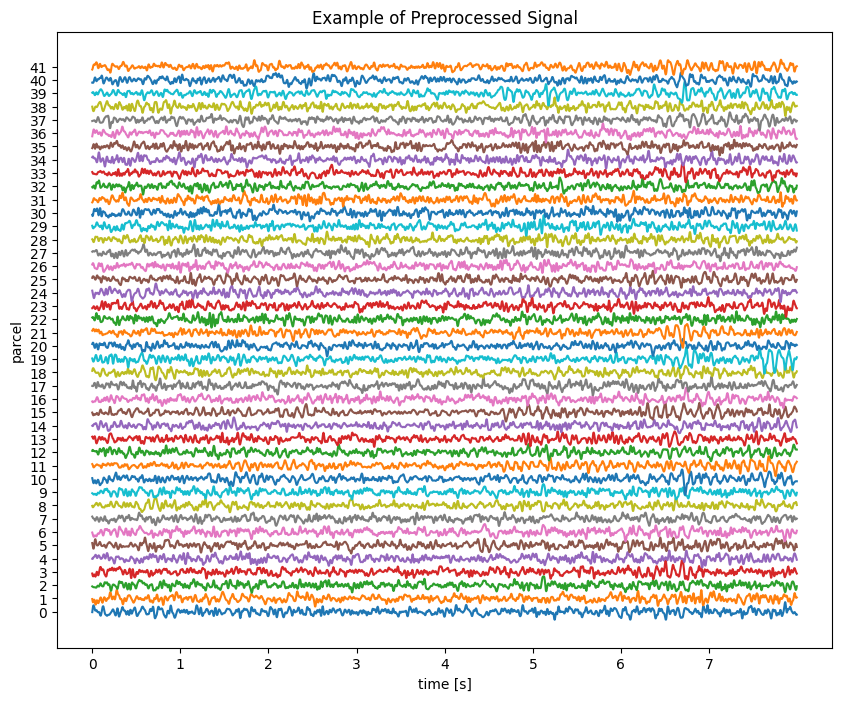

In [8]:
# visualize some data
# decide on a plotting range of the signal 
plot_range = np.arange(200000,202000)

Fs = 250 # sampling frequency of the signal
n_regions = X_preproc.shape[1]

# plot each parcel separately
fig = plt.figure(figsize=(10,8))
for i in range(n_regions):
    plt.plot(X_preproc[plot_range,i]+i*5)

plt.xticks(np.arange(0,len(plot_range),Fs),np.arange(int(len(plot_range)/Fs)))
plt.xlabel('time [s]')
plt.yticks(np.arange(0,n_regions*5,5),np.arange(n_regions))
plt.ylabel('parcel')
plt.title('Example of Preprocessed Signal')
plt.show()

### Initialise and train a TDE-HMM  <a id="initialise-hmm-tde"></a>
We first initialise the glhmm object, which we here call `TDE_hmm`. By specifying the parameters of the glhmm object, we define which type of model we want to fit and how states should be defined. 

In the case of the TDE-HMM, this is done with two steps: we will first embed the data within a window of lags, then we will run a default (i.e. Gaussian) HMM on the embedded data. 

For the first step, we will use the `build_data_tde`option in the preprocessing module. This will create an embedded version of the data according to the **lags** we define. The lags will indicate the length and resolution of the window to use to embed the data. In this specific case, our window of lags will be from -7 to +7 with unit step: `embedded_lags = np.arange(-7,8)`. We will then use PCA on the embedded signal, using number of PC=number of parcels * 2, to follow the original [TDE-HMM paper](https://doi.org/10.1038/s41467-018-05316-z) preprocessing and HMM settings.

We will then run a Gaussian HMM on the embedded data, to capture the autocovariance of the signal. 

We model 10 states by setting the parameter `K=6`. We will also specify the covariance type as `covtype='full'` and no means modelling. So our states will be characterised only by functional connectivity (covariance).

In [9]:
# Specify time lags
embedded_lags = 15
lags = np.arange(-embedded_lags, embedded_lags + 1)

# Build the MEG data in TDE format
X_embedded, idx_tde, pca_model = preproc.build_data_tde(X_preproc,idx_data,lags=lags,pca=n_regions*2)

In [10]:
# instantiate model
TDE_hmm = glhmm.glhmm(model_beta='no', model_mean='state', K=6, covtype='full')

In [11]:
# train HMM
print('Training HMM-TDE')

stc_tde, xi_tde, fe_tde = TDE_hmm.train(X=None, Y=X_embedded, indices=idx_tde)
vpath_tde = TDE_hmm.decode(X=None, Y=X_embedded, viterbi=True)


Training HMM-TDE


/Users/au673157/anaconda3/lib/python3.11/site-packages/glhmm/auxiliary.py:241: RuntimeWarning: invalid value encountered in divide
  a[t,:,:] = a[t,:,:] / xp.expand_dims(sc[t,:],axis=1)


Init repetition 1 free energy = 83934189.37064332
Init repetition 2 free energy = 83935549.88869242
Init repetition 3 free energy = 84131205.80814037
Init repetition 4 free energy = 84116982.88214278
Init repetition 5 free energy = 83960044.56208292
Best repetition: 1
Cycle 1 free energy = 83929996.72268656
Cycle 2 free energy = 83924818.6208104
Cycle 3, free energy = 83921465.71551731, relative change = 0.39302572680737863
Cycle 4, free energy = 83919369.61349458, relative change = 0.19724103562597822
Cycle 5, free energy = 83917719.7233884, relative change = 0.13438871063707525
Cycle 6, free energy = 83916474.05271274, relative change = 0.09211721339622482
Cycle 7, free energy = 83915445.91890037, relative change = 0.07065821431416879
Cycle 8, free energy = 83914749.91626734, relative change = 0.045649076527766876
Cycle 9, free energy = 83914193.04033825, relative change = 0.035237099608428774
Cycle 10, free energy = 83913874.6787198, relative change = 0.019746976196120442
Cycle 11, 

In [12]:
# save your trained hmm
hmm_dict = {'hmm':TDE_hmm,'stc':stc_tde,'xi':xi_tde,'fe':fe_tde,'vpath':vpath_tde}
with open("./example_data/hmm_tde.pkl", "wb") as fp:
    pickle.dump(hmm_dict, fp, pickle.HIGHEST_PROTOCOL)

### ... or load a pre-trained hmm

If you are short on time and do not want to initialise and train an HMM on these data, you can download and load a pre-trained hmm with the same settings. This is done in the next cell

In [13]:
! osf -p 8qcyj fetch MEG_data/hmm_tde.pkl ./example_data/hmm_tde.pkl

usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./example_data/hmm_tde.pkl already exists, not overwriting.


In [14]:
# load into the notebook
with open('./example_data/hmm_tde.pkl', "rb") as f:
    hmm_dict = pickle.load(f)

TDE_hmm = hmm_dict['hmm']
stc_tde = hmm_dict['stc']
vpath_tde = hmm_dict['vpath']

### Inspect model <a id="inspect-model"></a>

compute metrics and plot them.

#### Note: because of the data embeddings, the vpath and gamma (state time courses) are not of the same dimensions of the original data. For this reason we need to re-align them with the data (padGamma function) to plot them.

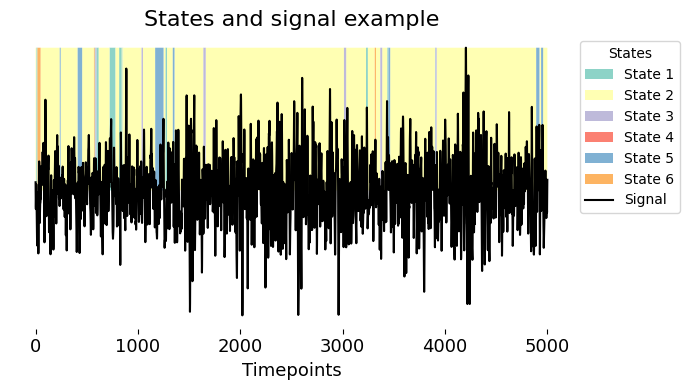

In [16]:
# apply the padGamma function to the vp to plot states and signal
T = auxiliary.get_T(idx_data)
options_tde = {'embeddedlags':list(lags)}
paddedVP = auxiliary.padGamma(vpath_tde, T, options_tde)


# plot state time courses with signal
plotting_range = np.arange(15000,20000)
graphics.plot_vpath(paddedVP[plotting_range], signal=X_preproc[plotting_range,1]/np.max(X_preproc[plotting_range,1]), title="States and signal example")


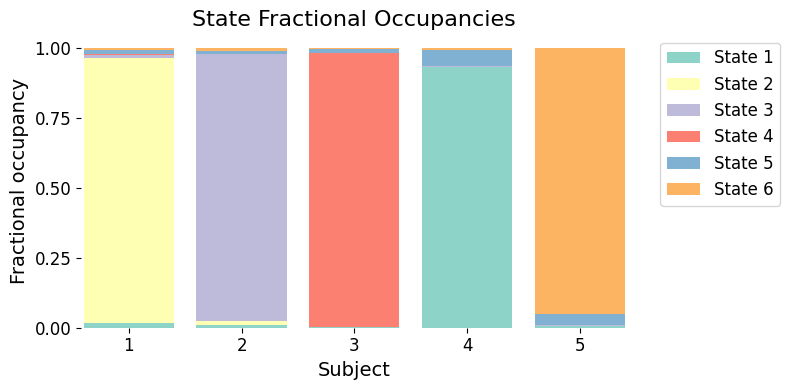

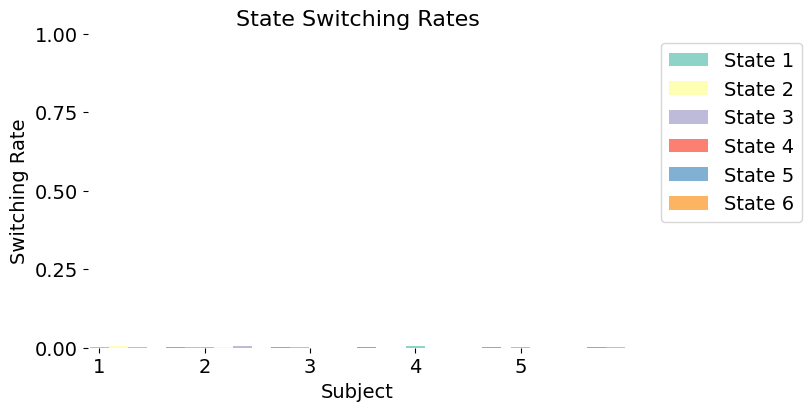

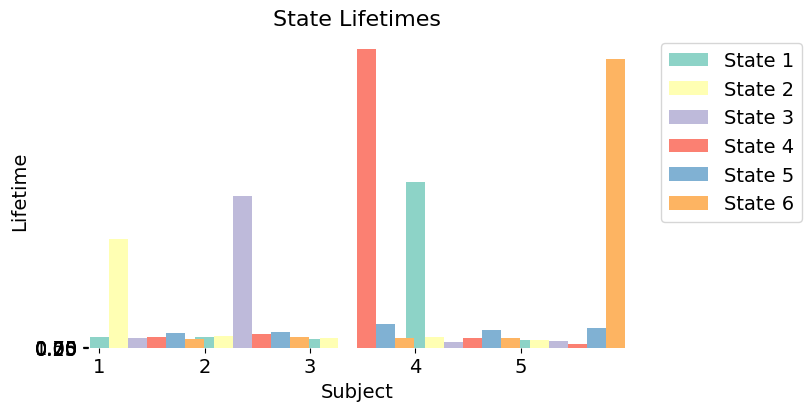

In [17]:
# inspect states - basic sanity checks
FO = utils.get_FO(stc_tde, indices=idx_tde)
SR = utils.get_switching_rate(stc_tde, indices=idx_tde)
LTmean, LTmed, LTmax = utils.get_life_times(vpath_tde, indices=idx_tde)

# plot some relevant statistics
graphics.plot_FO(FO)
graphics.plot_switching_rates(SR)
graphics.plot_state_lifetimes(LTmed)

#### State  covariances 
We have defined the model so that each state has a covariance (functional connectivity). We can retrieve them by using the `get_covariance_matrix` functions:

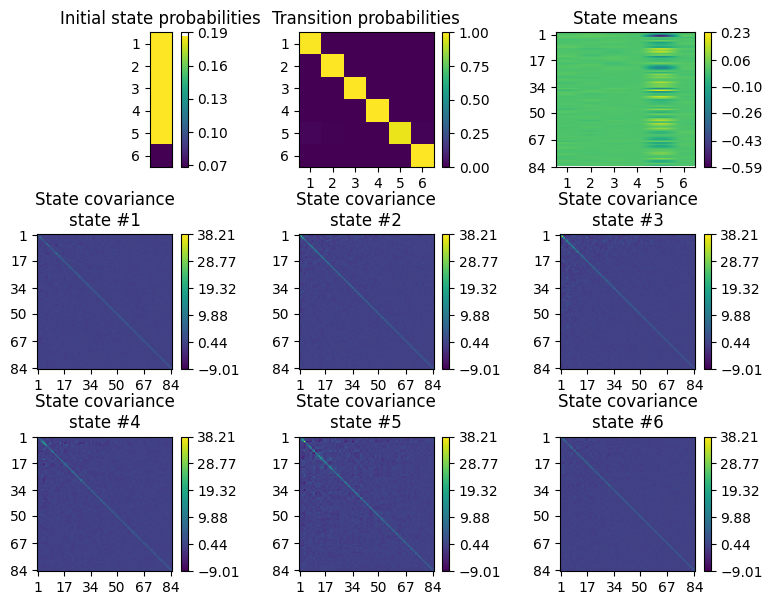

In [18]:
graphics.plot_state_prob_and_covariance(TDE_hmm.Pi,TDE_hmm.P, TDE_hmm.get_means(),TDE_hmm.get_covariance_matrices())

### Spectral analysis <a id="spectral-tde"></a>

We will now use the spectral package to compute the states power spectra and coherence, and plot them.

This is done with the function `spectral.multitaper_spectral_analysis` that computes the states spectra using the non parametric multitaper approach. The function outputs a dictionary with the states power spectrum, states cross-channel coherence and cross-channel spectra. 

The function needs as compulsory input the sampling frequency Fs of the data, which in our case is 250Hz, so we will specify `Fs=250`. The function also needs the Gamma (i.e., the state probability time courses) to compute the power spectrum of each state. We can input the padded Gamma, or the original gamma, specifying in the options the `embeddedlags` used to train the HMM. In this last case, the function will pad the Gamma first.

You can also specify in the options for the spectral analysis `fpass`, the frequency range for the power spectrum estimation. 

In [19]:
# -------------------------------------------------------------------
# get states spectral properties
options_tde = {'embeddedlags':list(lags), 'fpass':[0,100]}
spectral_measures = spectral.multitaper_spectral_analysis(X_preproc, idx_data, Fs=250, Gamma=stc_tde, options=options_tde)

/Users/au673157/anaconda3/lib/python3.11/site-packages/glhmm/spectral.py:308: ComplexWarning: Casting complex values to real discards the imaginary part
  psdc[j,:,:,:,k] = psdc_sk.transpose(2,0,1)


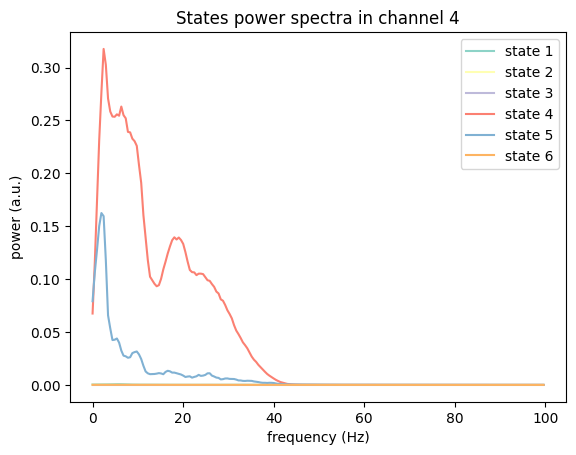

In [20]:
# plot the state power spectra for a specific session, and channel
K=6
select_channel = 4
select_session = 2
cmap = plt.get_cmap('Set3')
component_colors = [cmap(i) for i in range(K)]
f = spectral_measures['f']
psd = spectral_measures['p']
fig = plt.figure()
for k in range(K):
    plt.plot(f,psd[select_session,:,select_channel,k], color=component_colors[k],label='state %d'%(k+1))
    plt.xlabel('frequency (Hz)')
    plt.ylabel('power (a.u.)')
    plt.legend()
    plt.title("States power spectra in channel %d"%select_channel)
plt.show()


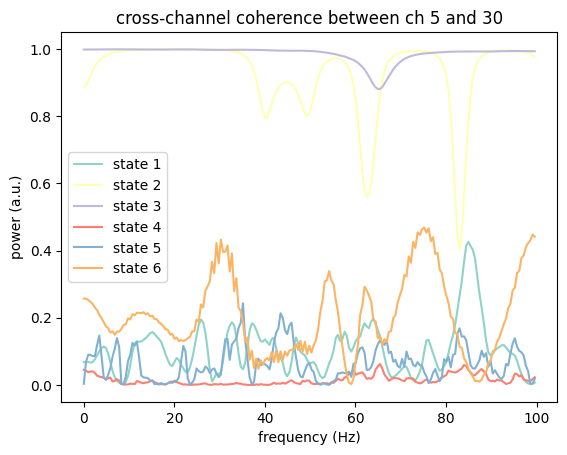

In [21]:
# for a specific session, plot the state coherence between two channels
coh = spectral_measures['coh']
chann_1 = 5
chann_2 = 30
fig = plt.figure()
for k in range(K):
    plt.plot(f,coh[select_session,:,chann_1,chann_2,k],color=component_colors[k], label='state %d'%(k+1))
    plt.xlabel('frequency (Hz)')
    plt.ylabel('power (a.u.)')
    plt.legend()
    plt.title("cross-channel coherence between ch %d and %d"%(chann_1,chann_2))
plt.show()

## MAR-HMM Example: two-channel MEG data <a id="HMM-MAR"></a>

For this example, we will use MEG data from subjects performing a simple motor task. The data consist of 10 minute sessions of subjects who were asked to rest and tap with their left finger once every roughly 30 seconds (but without counting the time in between taps). 

Each subject session data is stored as a 2D matrix with the shape of (No. of timepoints, No. of channels). Here there are only two channels from the motor cortex.

We will use a subset of data collected and used for the original [MAR-HMM paper](https://www.sciencedirect.com/science/article/pii/S1053811915010691)

#### Note: this part will repeat some of the analysis steps done for the TDE-HMM (e.g., inspecting the model, spectral analysis). The repeated passages will not be explained again step by step like above. 

### Load and preprocess data <a id="load-data-mar"></a>
Donwload the data from the OSF website and into 'example_data' folder. If you prefer, you can also directly download the files from the [OSF project page](https://osf.io/8qcyj/?view_only=119c38072a724e0091db5ba377935666).

In [22]:
! osf -p 8qcyj fetch MEG_data/data_MEG_MAR.pkl ./example_data/data_MEG_MAR.pkl

usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./example_data/data_MEG_MAR.pkl already exists, not overwriting.


In [23]:
# Loading the data in the notebook

with open("./example_data/data_MEG_MAR.pkl", "rb") as f:
    data_meg_mar = pickle.load(f)

# Display data information
print(f"Number of subjects in data_meg: {len(data_meg_mar)}")

Number of subjects in data_meg: 4


In [24]:
# concatenate subject data
X_concat = []
for j in range(len(data_meg_mar)):
    X_concat.extend(data_meg_mar[j])

X_concat = np.array(X_concat)

# Get the start and end indices for each session
idx_data = statistics.get_indices_from_list(data_meg_mar)


In [25]:
# show the indices of the subject/session dat
idx_data

array([[     0, 300000],
       [300000, 540000],
       [540000, 762000],
       [762000, 996000]])

In [26]:
# Preprocess data
X_preproc = preproc.preprocess_data(X_concat, idx_data)[0]


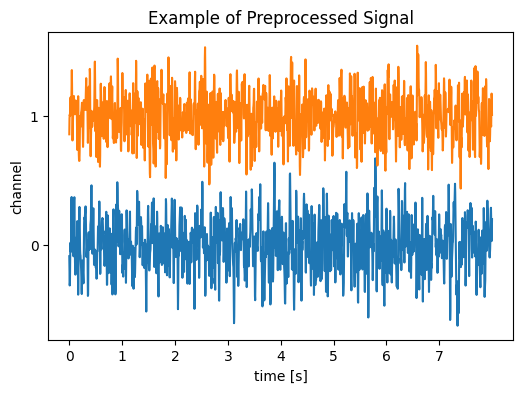

In [27]:
# visualize some data
# decide on a plotting range of the signal 
plot_range = np.arange(200000,202000)

Fs = 250 # sampling frequency of the signal
n_regions = X_preproc.shape[1]

# plot each parcel separately
fig = plt.figure(figsize=(6,4))
for i in range(n_regions):
    plt.plot(X_preproc[plot_range,i]+i*5)

plt.xticks(np.arange(0,len(plot_range),Fs),np.arange(int(len(plot_range)/Fs)))
plt.xlabel('time [s]')
plt.yticks(np.arange(0,n_regions*5,5),np.arange(n_regions))
plt.ylabel('channel')
plt.title('Example of Preprocessed Signal')
plt.show()

### Initialise and train a MAR-HMM  <a id="initialise-hmm-mar"></a>
We first initialise the glhmm object, which we here call `MAR_hmm`. By specifying the parameters of the glhmm object, we define which type of model we want to fit and how states should be defined. 

In the case of the MAR-HMM, this is done with two steps: we will first construct the data to regress, and the data to predict, then we will run a decoding (i.e. Gaussian Linear) HMM on the embedded data. For more information about the decoding (Gaussian Linear) HMM, see the paper [Vidaurre et al., (2025)](https://doi.org/10.1016/j.neuroimage.2015.11.047) and the notebook [GLHMM_example](./GLHMM_example.ipynb).

For the first step, we will use the `build_data_mar`option in the preprocessing module. This will create an embedded version of the data X and Y, so that in the GLHMM X will be used to predict Y. To create the X and Y embeddings of the data, the function will need the **order**, indicating how many points back in time will be used to predict the next time point. In this specific case, we will use `order=5`. See original [MAR-HMM paper](https://doi.org/10.1016/j.neuroimage.2015.11.047) for more information about the model. 

We will then run a GLHMM on the embedded data, to predict Y from X. 

We model 4 states by setting the parameter `K=3`. We will also specify the covariance type as `covtype='full'` and no means modelling. So our states will be characterised only by functional connectivity (covariance).

In [28]:
# build data MAR
autoregressive_order = 5
data = preproc.build_data_autoregressive(X_preproc,idx_data,autoregressive_order)
X_embed = data[0]
Y_embed = data[1]
idx_mar = data[2].astype(int)

In [29]:
# instantiate model
MAR_hmm = glhmm.glhmm(model_beta='state', model_mean='state', K=3, covtype='full')

In [30]:
# train HMM
stc_mar, xi_mar, fe_mar = MAR_hmm.train(X=X_embed,Y=Y_embed,indices=idx_mar)

Init repetition 1 free energy = -409995.47743206273
Init repetition 2 free energy = -410007.32170446805
Init repetition 3 free energy = -409711.58471609437
Init repetition 4 free energy = -416096.45643933036
Init repetition 5 free energy = -410827.13787181646
Best repetition: 4
Cycle 1 free energy = -380134.8511688909
Cycle 2 free energy = -393346.9872322161
Cycle 3, free energy = -399627.6069583118, relative change = 0.3222027605508867
Cycle 4, free energy = -404563.0874407205, relative change = 0.20203998469182397
Cycle 5, free energy = -408425.376168671, relative change = 0.13652234194948656
Cycle 6, free energy = -411402.4979490233, relative change = 0.0952141298412003
Cycle 7, free energy = -413658.15037918993, relative change = 0.06728611095275565
Cycle 8, free energy = -415350.6004637728, relative change = 0.04805946539461588
Cycle 9, free energy = -416626.60474234546, relative change = 0.03496692138962858
Cycle 10, free energy = -417608.86580660404, relative change = 0.02621179

In [31]:
# get vpath
vpath_mar = MAR_hmm.decode(X=X_embed, Y=Y_embed, viterbi=True)

In [32]:
# save your trained hmm
hmm_dict = {'hmm':MAR_hmm,'stc':stc_mar,'xi':xi_mar,'fe':fe_mar,'vpath':vpath_mar}
with open("./example_data/hmm_mar.pkl", "wb") as fp:
    pickle.dump(hmm_dict, fp, pickle.HIGHEST_PROTOCOL)

#### or download the trained model 

In [33]:
# or download the trained model 
! osf -p 8qcyj fetch MEG_data/hmm_mar.pkl ./example_data/hmm_mar.pkl

usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./example_data/hmm_mar.pkl already exists, not overwriting.


In [34]:
# and load it into your notebook
# load into the notebook
with open('./example_data/hmm_mar.pkl', "rb") as f:
    hmm_dict = pickle.load(f)

MAR_hmm = hmm_dict['hmm']
stc_mar = hmm_dict['stc']
vpath_mar = hmm_dict['vpath']

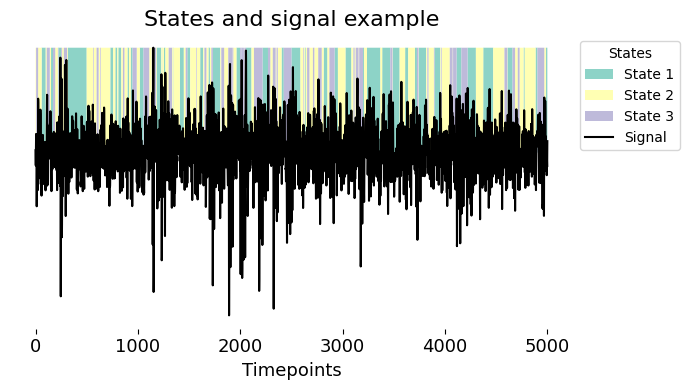

In [36]:
# Pad Gamma
T = auxiliary.get_T(idx_data)
options_mar ={'order':autoregressive_order}
paddedGamma = auxiliary.padGamma(stc_mar, T, options_mar)
paddedVP = auxiliary.padGamma(vpath_mar, T, options_mar)

# plot state time courses with signal
plotting_range = np.arange(5000,10000)
graphics.plot_vpath(paddedVP[plotting_range], signal=X_preproc[plotting_range,1]/np.max(X_preproc[plotting_range,1]), title="States and signal example")


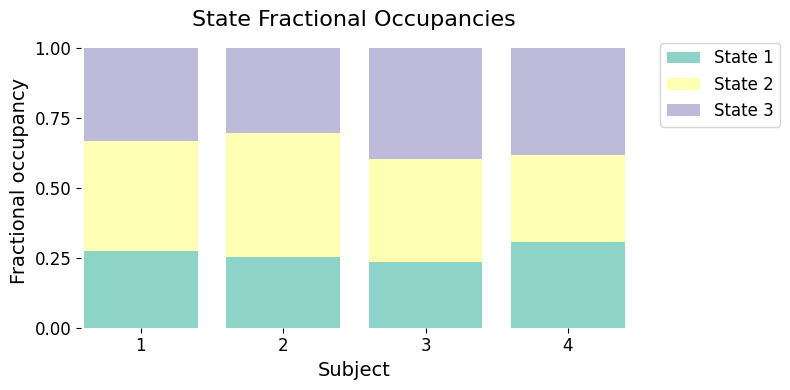

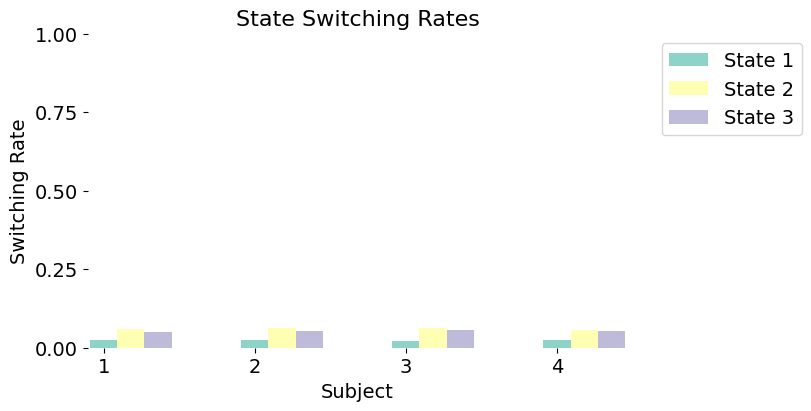

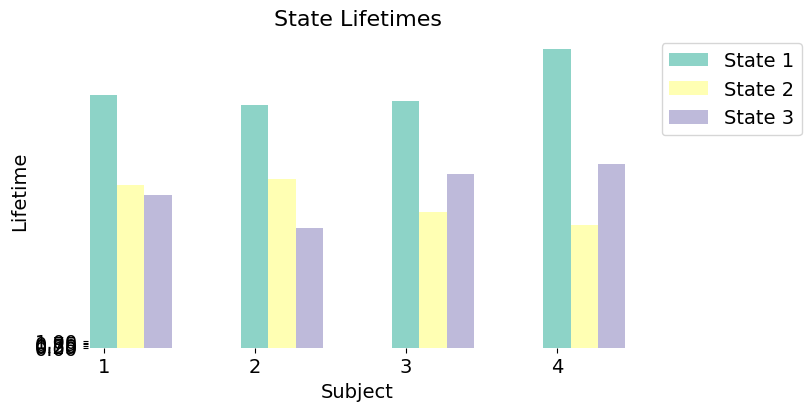

In [37]:
# inspect states metrics
FO = utils.get_FO(stc_mar, indices=idx_mar)
SR = utils.get_switching_rate(stc_mar, indices=idx_mar)
LTmean, LTmed, LTmax = utils.get_life_times(vpath_mar, indices=idx_mar)

# plot some relevant statistics
graphics.plot_FO(FO)
graphics.plot_switching_rates(SR)
graphics.plot_state_lifetimes(LTmean)

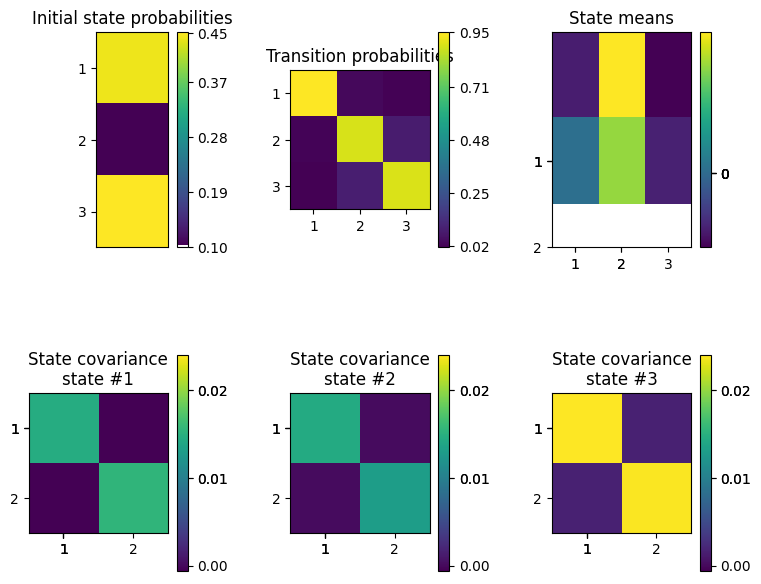

In [38]:
# plot the states covariance matrices
graphics.plot_state_prob_and_covariance(MAR_hmm.Pi,MAR_hmm.P, MAR_hmm.get_means(),MAR_hmm.get_covariance_matrices())

### Relate behavioural outcome to states probability <a id="onset"></a>

As mentioned, these data were recorded while subjects would rest and tap their left finger occasionally. We will now take the timings of the tappings and align the state time courses to them, to explore the relation between the states and correlates of movement in the data.

We will download the tapping onset from the OSF folder first.

This is stored as a boolean vector (indicating the exact tap timing) of shape (No. of timepoints).

In [39]:
# download onset
! osf -p 8qcyj fetch MEG_data/onset_tap_MAR.pkl ./example_data/onset_tap_MAR.pkl

usage: osf fetch [-h] [-f] [-U] remote [local]
osf fetch: error: Local file ./example_data/onset_tap_MAR.pkl already exists, not overwriting.


In [40]:
# load the onset data into the notebook
with open('./example_data/onset_tap_MAR.pkl', "rb") as f:
    onset = pickle.load(f)

In [41]:
# concatenate the onset 
onset_concat = []

for i in range(len(onset)):
    onset_concat.extend(onset[i])
    
onset_concat = np.array(onset_concat)


# find the exact timing of the onset
onset_timing = np.where(onset_concat)[0]


In [42]:
# now select a window around the timings - let's say 4 seconds, from -2 to +2 after the tapping

state_around_tap = []
for i in onset_timing:
    state_around_tap.append(paddedGamma[i-500:i+501,:])
    
state_around_tap = np.array(state_around_tap)


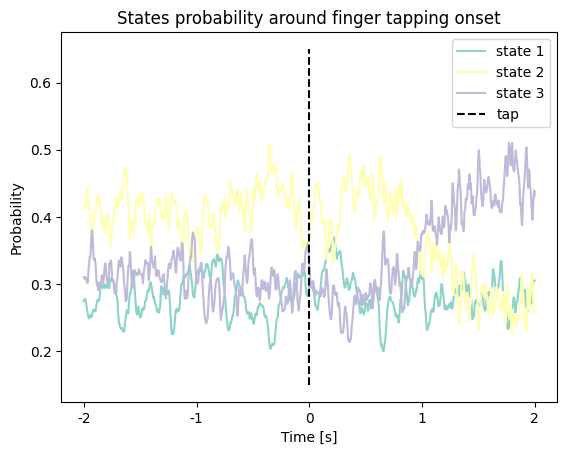

In [47]:
# plot average state probability around finger tapping
K=3
cmap = plt.get_cmap('Set3')
component_colors = [cmap(i) for i in range(K)]
plt.figure()
for k in range(K):
    plt.plot(np.arange(-500,501),np.mean(state_around_tap[:,:,k],0), color=component_colors[k], label='state %d'%(k+1))
plt.xticks(np.arange(-500,501,Fs), np.arange(-2,3))
plt.vlines(x=0, ymin=0.15,ymax=0.65,linestyle='--', color='k', label='tap')
#plt.yticks([0,0.5,1])
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Probability')
plt.title('States probability around finger tapping onset')
plt.show()

### Get states spectral properties  <a id="spectral-mar"></a>

In [48]:
# get states spectral properties
#options = {'order':autoregressive_order}
spectral_measures = spectral.multitaper_spectral_analysis(X_preproc, idx_data, Fs=250, Gamma=paddedGamma, options={'fpass':[0,50]})

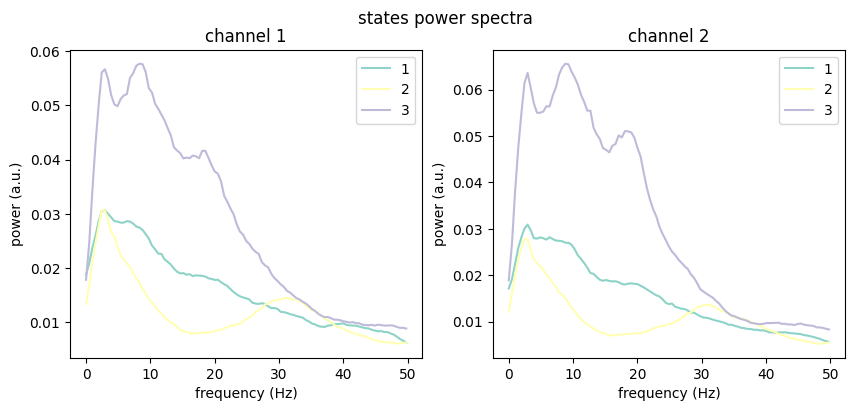

In [49]:
# plot state power spectra per channel
select_subject = 2
cmap = plt.get_cmap('Set3')
component_colors = [cmap(i) for i in range(K)]
f = spectral_measures['f']
psd = spectral_measures['p']
fig, axs= plt.subplots(ncols=2, figsize=(10,4))
for i in range(2):
    for k in range(K):
        axs[i].plot(f,psd[select_subject,:,i,k], color=component_colors[k],label='%d'%(k+1))
        axs[i].set_xlabel('frequency (Hz)')
        axs[i].set_ylabel('power (a.u.)')
        axs[i].legend()
        axs[i].set_title("channel %d"%(i+1))
fig.suptitle('states power spectra')
plt.show()
